## Create the dataset


In [3]:
!pip install datasets
!pip install -U datasets


In [40]:
from datasets import load_dataset

ds = load_dataset("roneneldan/TinyStories")

In [9]:
!pip install tiktoken


In [41]:
import tiktoken
import os
import numpy as np
import tqdm
from tqdm import tqdm



In [42]:
def process(example):
    import tiktoken
    enc = tiktoken.get_encoding("gpt2")

    ids = enc.encode_ordinary(example["text"])
    out = {'ids':ids, 'len':len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=["text"],
        desc="tokenizing the splits",
        num_proc=8,
    )
    # concatenate all the ids in each dataset into one large
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'],dtype=np.uint64)
        filename = f'{split}.bin'
        dtype=np.uint16
        arr =  np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True)
            arr_batch = np.concatenate(batch['ids'])
            arr[idx:idx+len(arr_batch)] = arr_batch
            idx+= len(arr_batch)
        arr.flush()


In [43]:
import torch

def get_batch(split):
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])

    if device_type == 'cuda':
        x = x.pin_memory().to(device, non_blocking=True)
        y = y.pin_memory().to(device, non_blocking=True)
    else:
        x = x.to(device)
        y = y.to(device)
    return x, y

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
from contextlib import nullcontext

import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)
    
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')

        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))
    
    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y
    

    

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [57]:
config = GPTConfig(
    block_size=128,
    vocab_size=50257,
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True,
)  

In [58]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [59]:
import torch
from contextlib import nullcontext

learning_rate = 1e-4
max_iters = 20000
warmup_steps = 1000
min_lr = 5e-4
eval_iters = 500
batch_size = 32
block_size = 128

gradient_accumulation_steps = 32

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type = 'cuda' if 'cuda' in device else 'cpu'

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [60]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR
model = GPT(config)
##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

C:\Users\shres\AppData\Local\Temp\ipykernel_20192\3141452839.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [61]:
def estimate_loss(model):
    out = {}
    model.eval()

    with torch.inference_mode():
        for split in ["train", "val"]:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [73]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4
max_iters = 20000
warmup_steps = 1000
min_lr = 5e-5
eval_iters = 200
batch_size = 32
block_size = 128

gradient_accumulation_steps = 32

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type = 'cuda' if 'cuda' in device else 'cpu'

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)


In [74]:
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

## put in weight decay, changed beta2 to 0.95

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer=optimizer, total_iters=warmup_steps) #Implement linear warmup
schedulerr_decay = CosineAnnealingLR(optimizer=optimizer, T_max=max_iters - warmup_steps, eta_min=min_lr) #Implement lr decay

scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, schedulerr_decay], milestones=[warmup_steps]) #Switching from warmup to decay

scaler = torch.amp.GradScaler(enabled=(dtype == 'float16'))

In [75]:
## Pre-train the SLM

best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

model = model.to(device)

for epoch in tqdm(range(max_iters)):
    if epoch%eval_iters == 0 and epoch != 0:
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val']<best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)
        
    X, y = get_batch('train')
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X,y)
        loss = loss/gradient_accumulation_steps
        scaler.scale(loss).backward()
    
    if((epoch+1)%gradient_accumulation_steps ==0) or (epoch+1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/20000 [00:00<?, ?it/s]

c:\Users\shres\miniconda3\envs\medsam\lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 200: train loss 9.7505, val loss 9.7529
The current learning rate: 0.00005
Epoch 400: train loss 9.4320, val loss 9.4375
The current learning rate: 0.00006
Epoch 600: train loss 9.1205, val loss 9.1286
The current learning rate: 0.00007
Epoch 800: train loss 8.6990, val loss 8.7048
The current learning rate: 0.00009


c:\Users\shres\miniconda3\envs\medsam\lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 8.3211, val loss 8.3234
The current learning rate: 0.00010
Epoch 1200: train loss 7.9471, val loss 7.9475
The current learning rate: 0.00010
Epoch 1400: train loss 7.5941, val loss 7.5877
The current learning rate: 0.00010
Epoch 1600: train loss 7.2042, val loss 7.2031
The current learning rate: 0.00010
Epoch 1800: train loss 6.8928, val loss 6.8927
The current learning rate: 0.00010
Epoch 2000: train loss 6.6118, val loss 6.6068
The current learning rate: 0.00010
Epoch 2200: train loss 6.3346, val loss 6.3399
The current learning rate: 0.00010
Epoch 2400: train loss 6.0714, val loss 6.0652
The current learning rate: 0.00010
Epoch 2600: train loss 5.8512, val loss 5.8480
The current learning rate: 0.00010
Epoch 2800: train loss 5.6618, val loss 5.6663
The current learning rate: 0.00010
Epoch 3000: train loss 5.4892, val loss 5.4911
The current learning rate: 0.00010
Epoch 3200: train loss 5.3100, val loss 5.3197
The current learning rate: 0.00010
Epoch 3400: trai

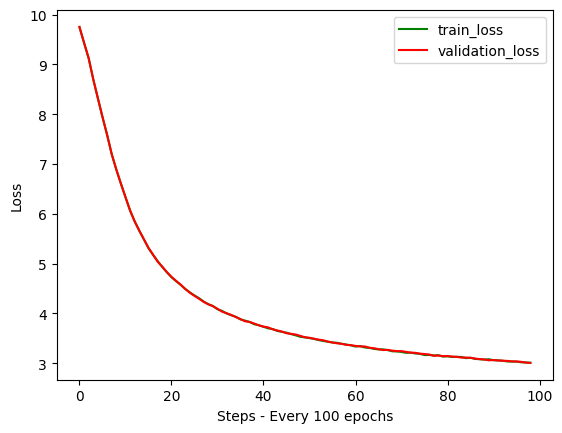

In [76]:
import matplotlib.pyplot as plt

train_loss_list_converted = [i.cpu().detach().numpy() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')

plt.xlabel('Steps - Every 100 epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
## Run SLM inference on our trained model

model = GPT(config)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_model_params_path = "best_model_params.pt"

model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))


<All keys matched successfully>

In [78]:
enc = tiktoken.get_encoding("gpt2")

In [80]:
sentence = "Once upon a time there was a pumpkin"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim=0))

y = model.generate(context, 200)

print(enc.decode(y[0].tolist()))


Once upon a time there was a pumpkin that started to open. It looked embarrassed because it could not find something yummy. It didn't come inside against the window anymore.

Theray was so colorful, but the wand was both missed who always look for herSuddenly, she heard a gift. She started to smile and she stacked itdrop. She saw that the swam was a big, pose.

Mia splashed down one mistake, especially brave ' Contextuse me see outside, you can help you." They went to the park asked the bar.

So, they reached the doctor picked up on the kitchen, andily was so troubled. She was happy and strong, gracefully!

But west was so free than Lily masseirl and hot gate nodded. She smiled and decided to put on her turn under her mug and skip together in the ocean. The end.Once upon a time, there was an Whenever it was towards- skating and hide. The ancient were forgotten near the sun and
